In [92]:
using Cxx
using PyCall
using PyPlot

@pyimport imageio
@pyimport skimage.filters as filters
@pyimport skimage.morphology as morphology
disk = morphology.disk;

In [125]:
include("src/Tracking.jl")

import Tracking
T = Tracking;

In [47]:
# video_file = "/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/ch02_20180330092923.mp4"
video_file = "/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/4K_hard_cut.mp4"

"/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/4K_hard_cut.mp4"

In [142]:
reader = imageio.get_reader(video_file);
#writer = imageio.get_writer("~/tmp/out.mp4", fps=reader[:get_meta_data]()["fps"]);

# frames = [T.preprocess_frame(reader[:get_data](i)) for i in 900:1400];
@time background = T.init_background(frames; max_iters=3);

134.522975 seconds (982.44 k allocations: 57.402 GiB, 3.19% gc time)


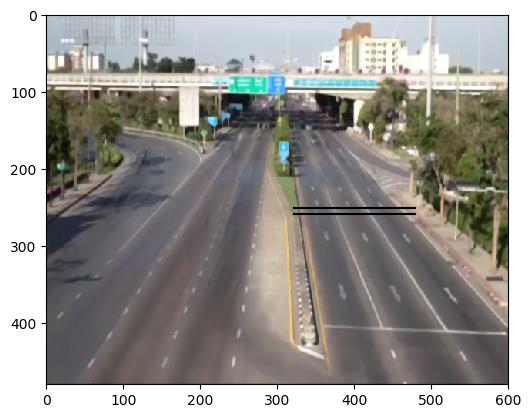

In [130]:
# slit_x = 285;
# slit_y = 200;
# slit_width = 80;
slit_x = 320;
slit_y = 250;
slit_width = 160;

block_width = 10;
block_height = 8;

imshow(background)
PyPlot.hlines(slit_y, xmin=slit_x, xmax=slit_x + slit_width)
PyPlot.hlines(slit_y + block_height, xmin=slit_x, xmax=slit_x + slit_width);

In [131]:
threshold = 0.05

0.05

In [629]:
include("src/StMrf.jl")
import StMrf
SM = StMrf;

include("src/Labeler.jl")
import Labeler
L = Labeler;

blocks = Array{SM.Block, 2}(floor(Int, size(background, 1) / block_height) - 1, floor(Int, size(background, 2) / block_width) - 1)
for row_id in 1:size(blocks, 1)
    const row_start = row_id * block_height;
    for col_id in 1:size(blocks, 2)
        const col_start = col_id * block_width;
        blocks[row_id, col_id] = SM.Block(col_start, row_start, block_width, block_height);
    end
end

slit_coords = [SM.get_block_coords(slit_x + i * block_width, slit_y, block_width, block_height) for i in 1:floor(Int, slit_width / block_width)]
slit_line = [blocks[c...] for c in slit_coords];

new_object_id = 1;
f_id = 400;

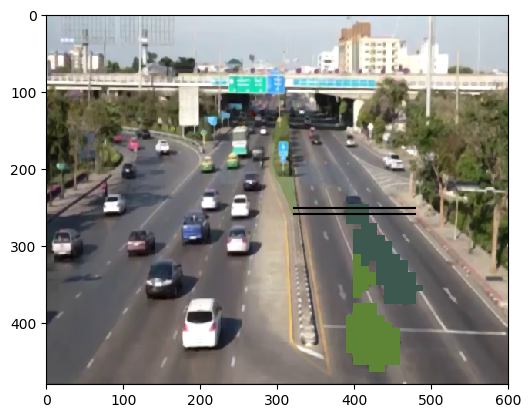

In [840]:
frame = frames[f_id];
# prev_pixel_map = zeros(Int, size(frame)[1:2])

for i in 1:5
    if f_id >= size(frames, 1)
        break
    end
    
    frame = frames[f_id];
    global prev_pixel_map = SM.blocks_to_object_map(blocks);
    last_id = SM.update_slit_objects!(blocks, slit_coords, frame, background, new_object_id; threshold=threshold);
    new_object_id = max(new_object_id, last_id)
    
    global old_frame = frame;
    frame = frames[f_id + 1];

    obj_ids_map = map(b -> b.object_id, blocks);

    global object_ids = sort(unique(obj_ids_map));
    object_ids = object_ids[object_ids .> 0]
    group_coords = [collect(zip(findn(obj_ids_map .== id)...)) for id in object_ids]
    global motion_vecs = [SM.find_motion_vector(blocks, frame, old_frame, gc) for gc in group_coords]
    
    if size(motion_vecs, 1) == 0
        f_id += 1
        continue
    end

    motion_vecs_rounded = [SM.round_motion_vector(mv, block_width, block_height) for mv in motion_vecs]
    global new_map = SM.update_object_ids(blocks, obj_ids_map, motion_vecs_rounded, group_coords, frame, background; 
                                   threshold=threshold);
    new_map[map(x -> x.end_y, blocks) .< slit_y] = Set();
    
    labels = L.label_map_gco(blocks, new_map, motion_vecs, prev_pixel_map, frame, old_frame);
    SM.set_block_ids!(blocks, labels)
    
    f_id += 1
end

plot_frame = deepcopy(frame);
for b in blocks
    if b.object_id == 0
        continue
    end

    srand(b.object_id)

    plot_frame[b.y_inds(), b.x_inds(),1] .= rand()
    plot_frame[b.y_inds(), b.x_inds(),2] .= rand()
    plot_frame[b.y_inds(), b.x_inds(),3] .= rand()
end

T.plot_frame(plot_frame, slit_x, slit_y, slit_width, block_height);

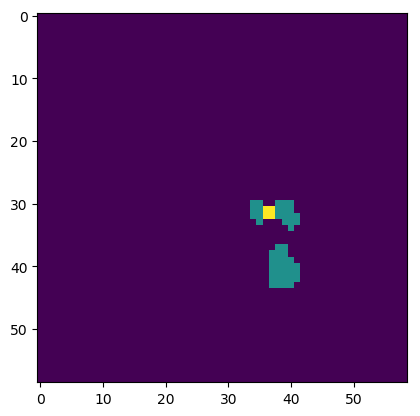

In [636]:
# imshow(prev_pixel_map);
imshow(map(length, new_map));

$U_N(N_{y_k})$: Pott's J = -$\alpha$;  
$M_{xy_k}$: number of overlapping pixel labels  
$D_{xy_k}$: image difference between a block in the previous frame and displaced block in the current frame;  

In [765]:
include("src/GcWrappers.jl")
import GcWrappers
GW = GcWrappers;

In [774]:
include("src/Labeler.jl")
import Labeler
L = Labeler;

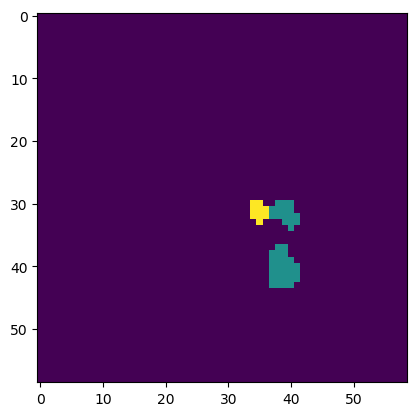

PyObject <matplotlib.image.AxesImage object at 0x7fc17b052240>

In [775]:
imshow(L.label_map_gco(blocks, new_map, motion_vecs, prev_pixel_map, frame, old_frame))

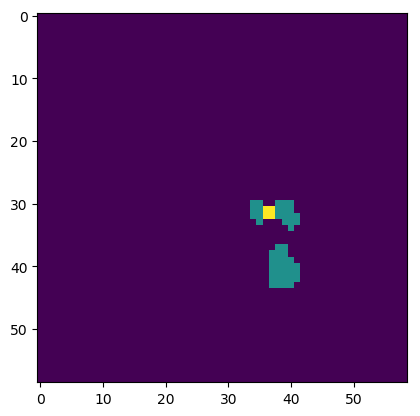

In [639]:
imshow(map(length, new_map));

In [762]:
tested_coords = collect(zip(findn(map(length, new_map) .> 1)...))

4-element Array{Tuple{Int64,Int64},1}:
 (32, 37)
 (33, 37)
 (32, 38)
 (33, 38)

In [688]:
new_map[tested_coords[1]...]

Set([2, 1])

In [717]:
obj_id = 2
block = blocks[tested_coords[4]...]
vec = motion_vecs[obj_id];
# prev_pixel_map[block.coords(-1 .* vec)...]

# 1 - cor(frame[block.coords()..., :][:], old_frame[block.coords(-1 .* vec)..., :][:])
# mean(abs.(frame[block.coords()..., :] .- old_frame[block.coords(-1 .* vec)..., :]))

[mean(prev_pixel_map[block.coords(-1 .* motion_vecs[id])...] .!= id) for id in 1:2]

2-element Array{Float64,1}:
 0.89899
 1.0    

In [769]:
tested_ids = [GW.id_by_coords(c..., size(blocks, 1), zero_based=false) for c in tested_coords];
println(tested_ids)

[2156, 2157, 2215, 2216]


In [770]:
include("src/Labeler.jl")
import Labeler
L = Labeler;

group_coords2 = [collect(zip(findn(map(v -> lab in v, new_map))...)) for lab in object_ids];
L.unary_penalties(blocks, object_ids, motion_vecs, group_coords2, prev_pixel_map, frame, old_frame)[tested_ids,1:2]

block.coords() = ([256, 257, 258, 259, 260, 261, 262, 263, 264], [370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380])
lab_diff = 1.0
block.coords() = ([264, 265, 266, 267, 268, 269, 270, 271, 272], [370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380])
lab_diff = 1.0
block.coords() = ([256, 257, 258, 259, 260, 261, 262, 263, 264], [380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390])
lab_diff = 0.1919191919191919
block.coords() = ([264, 265, 266, 267, 268, 269, 270, 271, 272], [380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390])
lab_diff = 0.898989898989899
block.coords() = ([256, 257, 258, 259, 260, 261, 262, 263, 264], [370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380])
lab_diff = 0.1919191919191919
block.coords() = ([264, 265, 266, 267, 268, 269, 270, 271, 272], [370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380])
lab_diff = 0.09090909090909091
block.coords() = ([256, 257, 258, 259, 260, 261, 262, 263, 264], [380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 39

4×2 Array{Int64,2}:
 -1032   -206
 -1059   -116
  -218  -1041
  -949  -1034

In [772]:
include("src/Labeler.jl")
import Labeler
L = Labeler;

group_coords2 = [collect(zip(findn(map(v -> lab in v, new_map))...)) for lab in object_ids];
L.unary_penalties(blocks, object_ids, motion_vecs, group_coords2, prev_pixel_map, frame, old_frame)[tested_ids,1:2]

4×2 Array{Int64,2}:
 -1032   -206
 -1059   -116
  -218  -1041
  -949  -1034

In [705]:
include("src/Labeler.jl")
import Labeler
L = Labeler;

group_coords2 = [collect(zip(findn(map(v -> lab in v, new_map))...)) for lab in object_ids];
L.unary_penalties(blocks, object_ids, motion_vecs, group_coords2, prev_pixel_map, frame, old_frame)[tested_ids,1:2]

4×2 Array{Int64,2}:
 -1000  -1000
 -1000  -1000
 -1000  -1000
 -1000  -1000